In [17]:
import llvmlite.binding as llvm
import copy
from random import choice
from typing import Optional, Union, Any, Set, List, Tuple, Dict, Collection
from llvmlite.binding import ValueRef
import matplotlib.pyplot as plt
import networkx as nx


class Graph:
    """
    The register interference graph.
    """

    def __init__(self):
        self._adjacency_list = {}

    def __copy__(self):
        cls = self.__class__
        new_graph = self.__new__(cls)
        new_graph._adjacency_list = copy.deepcopy(self._adjacency_list)
        return new_graph

    def add_edge(self, x, y):
        """
        Add an edge to the graph.
        The interference graph is undirected so add_edge('a', 'b') and add_edge('b', 'a') have the same effect.
        """
        # Add y to x
        x_list = self._adjacency_list.get(x, [])
        if y not in x_list:
            x_list.append(y)
        self._adjacency_list[x] = x_list

        # Add x to y
        y_list = self._adjacency_list.get(y, [])
        if x not in y_list:
            y_list.append(x)
        self._adjacency_list[y] = y_list

    def contains_edge(self, x, y):
        return y in self._adjacency_list.get(x, [])

    def remove_node(self, node):
        if node in self._adjacency_list:
            self._adjacency_list.pop(node)
        for key in self._adjacency_list.keys():
            if node in self._adjacency_list.get(key):
                self._adjacency_list.get(key).remove(node)

    def rename_node(self, from_label, to_label):
        from_list = self._adjacency_list.pop(from_label, [])
        to_list = self._adjacency_list.get(to_label, [])
        self._adjacency_list[to_label] = list(set(from_list + to_list))

        for key in self._adjacency_list.keys():
            self._adjacency_list[key] = list(set(
                [to_label if value ==
                    from_label else value for value in self._adjacency_list[key]]
            ))

    def neighbors(self, x):
        return self._adjacency_list.get(x, [])

    def plot(self, coloring, title):
        G = nx.Graph()

        # Sorting to get repeatable graphs
        nodes = sorted(self._adjacency_list.keys())
        ordered_coloring = [coloring.get(node, 'grey') for node in nodes]
        G.add_nodes_from(nodes)

        for key in self._adjacency_list.keys():
            for value in self._adjacency_list[key]:
                G.add_edge(key, value)

        plt.title(title)
        nx.draw(G, pos=nx.circular_layout(G), node_color=ordered_coloring,
                with_labels=True, font_weight='bold')
        plt.show()

    def all_nodes(self):
        return self._adjacency_list.keys()


def color_graph(g: Graph, regs: Collection[str], colors: List[str]) -> Optional[Dict[str, str]]:
    if len(regs) == 0:
        return {}

    node = next((node for node in regs if len(
        g.neighbors(node)) < len(colors)), None)
    if node is None:
        return None

    g_copy = copy.copy(g)
    g_copy.remove_node(node)
    coloring = color_graph(g_copy, [n for n in regs if n != node], colors)
    if coloring is None:
        return None

    neighbor_colors = [coloring[neighbor] for neighbor in g.neighbors(node)]
    coloring[node] = [
        color for color in colors if color not in neighbor_colors][0]

    return coloring

def save() -> List[str]:
    return [f"pushq %r{x}" for x in range(8, 16)]

def restore() -> List[str]:
    return [f"popq %r{x}" for x in range(8, 16)][::-1]

def codeGenForFunc(fn: ValueRef) -> List[str]:
    funcName = fn.name
    print("codeGenForFunc", funcName)

    ins: List[ValueRef] = []
    allocas: Dict[str, int] = {}
    useDef: Dict[int, List[Any]] = {}
    labelToIdx: Dict[str, int] = {}

    for b in fn.blocks:
        labelToIdx[b.name] = len(
            [_ for _ in ins if _.opcode not in ["alloca"]])  # TODO ensure this
        ins += [_ for _ in b.instructions]
    # if '' in labelToIdx.keys():
    labelToIdx.pop("")

    print(labelToIdx)

    idxToLabel = {value: key for key, value in labelToIdx.items()}

    # collect allocas and construct use-def chain
    idx = 0
    for i in ins:
        op = i.opcode
        if op == "alloca":
            # TODO spill also increase size
            if str(i.type) == "i32*":
                # allocas[i.name] = 4
                allocas[i.name] = 8
            else:
                allocas[i.name] = 8
            idx -= 1
        elif op == "store":
            use = []
            for j in i.operands:
                if j.name != "" and j.name not in allocas:
                    use.append(j.name)
            useDef[idx] = [i, set(use), set()]
        elif op == "br":
            use = []
            for j in i.operands:
                if str(j.type) != "label":
                    if j.name != "" and j.name not in allocas:
                        use.append(j.name)
            useDef[idx] = [i, set(use), set()]
        elif op == "call":
            use = []
            defs = []
            if i.name != "":
                defs.append(i.name)
            for j in i.operands:
                isFnType = '(' in str(j.type) and ')' in str(j.type)
                if not isFnType and j.name != "" and j.name not in allocas:
                    use.append(j.name)
            useDef[idx] = [i, set(use), set(defs)]
        else:
            use = []
            defs = []
            if i.name != "":
                defs.append(i.name)
            for j in i.operands:
                if j.name != "" and j.name not in allocas:
                    use.append(j.name)
            useDef[idx] = [i, set(use), set(defs)]
        idx += 1

    # get succ
    for idx in useDef:
        if idx == len(useDef)-1:
            useDef[idx].insert(1, [])
            continue
        theI = useDef[idx][0]
        op = theI.opcode
        if op == "br":
            print(theI)
            labels: List[ValueRef] = [
                _ for _ in theI.operands if str(_.type) == "label"]
            useDef[idx].insert(1, [labelToIdx[_.name] for _ in labels])
        else:
            useDef[idx].insert(1, [idx+1])

    # print useDef
    for i in useDef:
        print(i, useDef[i][1:])

    # get out in
    theIn = [set() for _ in useDef]
    theOut = [set() for _ in useDef]
    theIn2 = [set() for _ in useDef]
    theOut2 = [set() for _ in useDef]

    init = 1

    def pretty(s: Set[str]):
        return "{" + ", ".join(s) + "}"

    def done():
        nonlocal init
        if init:
            init = 0
            return False
        for i in range(len(theIn)):
            if theIn[i] != theIn2[i] or theOut[i] != theOut2[i]:
                return False
        print("done")
        return True

    count = 0
    while not done():
        # for ff in range(9):
        count += 1
        theIn2 = copy.deepcopy(theIn)
        theOut2 = copy.deepcopy(theOut)
        # reverse
        for idx in range(len(useDef)-1, -1, -1):
            theIn[idx] = useDef[idx][2] | (theOut[idx] - useDef[idx][3])
            theOut[idx] = set()
            for succ in useDef[idx][1]:
                theOut[idx] |= theIn[succ]
    print("count", count)

    # print def use in out
    for i in range(len(theIn)):
        print(i, pretty(useDef[i][3]), pretty(useDef[i][2]),
              "|", pretty(theIn[i]), pretty(theOut[i]))

    print(allocas)
    local = 8 * len(allocas)
    print(local)

    allTemp = set.union(*([useDef[idx][2]
                        for idx in useDef] + [useDef[idx][3] for idx in useDef]))
    print(allTemp)

    def build_graph() -> Graph:
        g = Graph()
        # for t in allTemp:
        #     print("add", t)
        #     g.add_edge(t, t)
        for idx in useDef:
            outs = theOut[idx]
            defs = useDef[idx][3]
            for aDef in defs:
                for aOut in outs:
                    if aDef != aOut:
                        print("add", aDef, aOut)
                        g.add_edge(aDef, aOut)
        return g

    g = build_graph()
    colors = [i for i in range(8)]
    coloring = color_graph(g, list(allTemp), colors)
    print("coloring", coloring)
    g.plot(coloring, "Interference Graph")
    print("single nodes:", set(allTemp) - set(g.all_nodes()))
    print("color needed:", len(set(coloring.values())))
    # get depth in the stack
    depth: Dict[str, int] = {}
    for k, v in allocas.items():
        sum = 0
        for k2, v2 in allocas.items():
            sum += v2
            if k == k2:
                break
        depth[k] = sum
    print("depth", depth)

    # to real register
    def toR(reg: str | ValueRef, deRefer=False) -> str:
        if reg.name != '':
            reg = reg.name
        else:
            reg = str(reg)
        # now: "i32 0" / "t99"
        print("toR", reg)  # debug
        if 'i32' in reg or 'i64' in reg:
            _, n = reg.split(' ')
            return f"${n}"
        elif '.arg' in reg:
            _, n = reg.split('.arg')
            n = int(n)
            if n == 0:
                return "%rdi"
            elif n == 1:
                return "%rsi"
            elif n == 2:
                return "%rdx"
            elif n == 3:
                return "%rcx"
            elif n == 4:
                raise Exception("too many args (>4)")
        elif deRefer and 'local_' in reg:
            return f'-{depth[reg]}(%rbp)'
        if deRefer:
            return f'(%r{coloring[reg]+8})'
        return f"%r{coloring[reg]+8}"

    asm: List[str] = []
    asm += [f"\t.globl {funcName}"]
    asm += [f"\t{funcName}:"]
    asm += [f"pushq %rbp"]
    asm += [f"movq %rsp, %rbp"]
    asm += [f"subq ${local}, %rsp"]
    asm += save()
    brType = 'jz'  # for and or
    for idx in useDef:
        i: ValueRef = useDef[idx][0]
        print(">", i)
        op = i.opcode
        regs = [_ for _ in i.operands]
        cmds = []
        # insert label
        label = idxToLabel.get(idx, None)
        if label != None:
            asm += [f'\t{label}:']
        if op == "add":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # TODO check for other cases!
            # do not overwrite rs2
            if rd == rs2: 
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"addq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "sub":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # do not overwrite rs2
            if rd == rs2: 
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"subq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "or":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # do not overwrite rs2
            if rd == rs2: 
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"orq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "and":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # do not overwrite rs2
            if rd == rs2: 
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"andq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "mul":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            insert = []
            toProtect = ['%rax', '%rdx']
            # need to allocate a reg for const
            if '$' in rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += [f"movq {rs1}, %rax"]
            cmds += insert
            cmds += [f"imulq {rs2}"]
            cmds += [f"movq %rax, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == "sdiv":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            insert = []
            toProtect = ['%rax', '%rdx']
            # need to allocate a reg for const
            if '$' in rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += [f"movq {rs1}, %rax"]
            cmds += [f"cqto"]
            cmds += insert
            cmds += [f"idivq {rs2}"]
            cmds += [f"movq %rax, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == "srem":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            insert = []
            toProtect = ['%rax', '%rdx']
            # need to allocate a reg for const
            if '$' in rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += [f"movq {rs1}, %rax"]
            cmds += [f"cqto"]
            cmds += insert
            cmds += [f"idivq {rs2}"]
            cmds += [f"movq %rdx, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == 'store':
            rs = toR(regs[0])
            rd = toR(regs[1], True)
            cmd = f"movq {rs}, {rd}"
            cmds = [cmd]
        elif op == 'load':
            rd = toR(i)
            rs = toR(regs[0], True)
            cmd = f'movq {rs}, {rd}'
            cmds = [cmd]
        elif op == 'icmp':
            # slt, ...
            exactType = str(i).split('icmp ')[1].split()[0]
            # ! assert first label is always next
            theMap = {
                'eq': 'jne',
                'ne': 'je',
                'slt': 'jge',
                'sle': 'jg',
                'sgt': 'jle',
                'sge': 'jl',
            }
            tryGet = theMap.get(exactType, None)
            if tryGet != None:
                brType = tryGet
            else:
                raise Exception("Unknown icmp type")
            a = toR(regs[0])
            b = toR(regs[1])
            # this is "a-b"
            cmds = [f"cmpq {b}, {a}"]
        elif op == 'br':
            labels = []
            for j in regs:
                if str(j.type) == "label":
                    labels += [j.name]
            labels.reverse() # the right order
            if len(labels) == 1 and labelToIdx.get(labels[0]) != idx+1:
                cmds = [f"jmp {labels[0]}"]
            elif len(labels) == 2:
                # asm += [f"\t{str(labels)}"]
                cmds = [f"{brType} {labels[1]}"]
        elif op == 'call':
            rd = toR(i) if i.name != '' else None
            fn = regs[-1].name + "@PLT"
            args = [toR(_) for _ in regs[:-1]]
            theMap = {
                0: "%rdi",
                1: "%rsi",
                2: "%rdx",
                3: "%rcx",
            }
            # args
            for x, arg in enumerate(args):
                if x < 4:
                    cmds += [f"movq {arg}, {theMap[x]}"]
                else:
                    cmds += [f"pushq {arg}"]
            cmds += [f"call {fn}"]
            if rd != None:
                cmds += [f"movq %rax, {rd}"]
        elif op == 'ret':
            if len(regs) != 0:
                res = toR(regs[0])
                cmds += [f"movq {res}, %rax"]
                cmds += [f"jmp {funcName}_end"]
        elif op == 'getelementptr':
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            cmd = f"leaq ({rs1},{rs2},{8}), {rd}"
            cmds = [cmd]
        elif op == 'bitcast':
            rs = toR(regs[0])
            rd = toR(i)
            cmd = f"movq {rs}, {rd}"
            cmds = [cmd]
        else:
            cmds = ["!!!TODO!!!"]

        if op != 'icmp':
            brType = 'jz'  # abondon if not used
        asm += [f'  #{str(i)}']
        asm += cmds
        print("  -", cmds)

    asm += [f"\t{funcName}_end:"]
    asm += restore()
    asm += [f"movq %rbp, %rsp"]
    asm += [f"popq %rbp"]
    asm += [f"retq"]

    print("-- ASM: --")
    print("\n".join(asm))

    return asm


def codeGen(fileName: str) -> List[List[str]]:
    llvm.initialize()
    ir = open(fileName).read()
    # the ModuleRef
    mod = llvm.parse_assembly(ir)
    mod.verify()
    print(mod.triple)
    asms = []
    for fn in mod.functions:
        if fn.is_declaration:
            continue
        asm = codeGenForFunc(fn)
        asms.append(asm)
    # llvm.shutdown()
    return asms


def ll2asm(inFile, outFile):
    asms = codeGen(inFile)
    flat = '\t.text\n'
    flat += '\n'.join(['\n'.join(x + ['']) for x in asms])
    with open(outFile, 'w') as f:
        f.write(flat)

x86_64-pc-linux-gnu
codeGenForFunc main_getInt
{'for.cond0.3': 7, 'for.body0.5': 15, 'if.body1.16': 19, 'if.end1.18': 23, 'for.post0.4': 26, 'for.end0.6': 27, 'for.cond2.25': 28, 'for.body2.27': 36, 'for.post2.26': 47, 'for.end2.28': 48}
  br label %for.cond0.3
  br i1 %t7, label %for.body0.5, label %for.end0.6
  br i1 %t19, label %if.body1.16, label %if.end1.18
  br label %if.end1.18
  br label %for.post0.4
  br label %for.cond0.3
  br label %for.cond2.25
  br i1 %t29, label %for.body2.27, label %for.end2.28
  br label %for.post2.26
  br label %for.cond2.25
0 [[1], set(), {'t0'}]
1 [[2], {'t0'}, set()]
2 [[3], set(), {'t1'}]
3 [[4], {'t1'}, set()]
4 [[5], set(), {'t2'}]
5 [[6], {'t2'}, set()]
6 [[7], set(), set()]
7 [[8], set(), {'t9'}]
8 [[9], set(), {'t10'}]
9 [[10], {'t10', 't9'}, {'t8'}]
10 [[11], set(), {'t12'}]
11 [[12], set(), {'t13'}]
12 [[13], {'t12', 't13'}, {'t11'}]
13 [[14], {'t8', 't11'}, {'t7'}]
14 [[27, 15], {'t7'}, set()]
15 [[16], set(), {'t20'}]
16 [[17], set(), {'t2

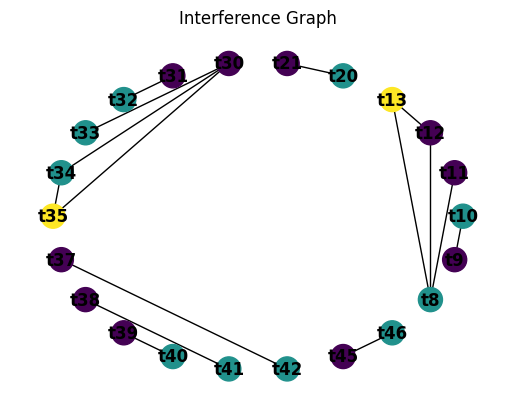

single nodes: {'t44', 't2', 't19', 't36', 't1', 't7', 't43', 't24', 't22', 't0', 't29', 't47', 't23'}
color needed: 3
depth {'local_sign.0': 8, 'local_n.1': 16, 'local_c.2': 24}
>   %t0 = add i64 0, 1
toR i64 0
toR i64 1
toR t0
  - ['movq $0, %r8', 'addq $1, %r8']
>   store i64 %t0, i64* %local_sign.0, align 4
toR t0
toR local_sign.0
  - ['movq %r8, -8(%rbp)']
>   %t1 = add i64 0, 0
toR i64 0
toR i64 0
toR t1
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t1, i64* %local_n.1, align 4
toR t1
toR local_n.1
  - ['movq %r8, -16(%rbp)']
>   %t2 = call i64 @getchar()
toR t2
  - ['call getchar@PLT', 'movq %rax, %r8']
>   store i64 %t2, i64* %local_c.2, align 4
toR t2
toR local_c.2
  - ['movq %r8, -24(%rbp)']
>   br label %for.cond0.3
  - []
>   %t9 = load i64, i64* %local_c.2, align 4
toR t9
toR local_c.2
  - ['movq -24(%rbp), %r8']
>   %t10 = add i64 0, 48
toR i64 0
toR i64 48
toR t10
  - ['movq $0, %r9', 'addq $48, %r9']
>   %t8 = icmp slt i64 %t9, %t10
toR t9
toR t10
  - ['cmpq %r9, %

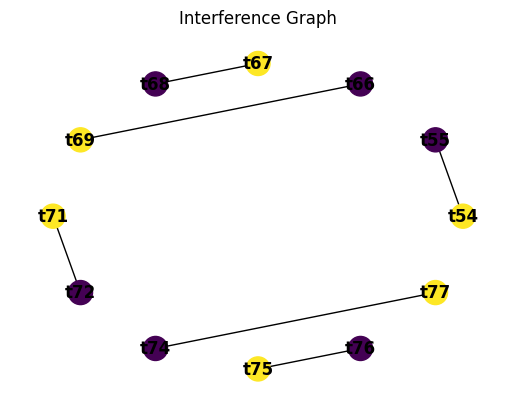

single nodes: {'local_n.3.arg0', 't59', 't53', 't57', 't73', 't65', 't78', 't56', 't70', 't58'}
color needed: 2
depth {'local_n.3': 8}
>   store i64 %local_n.3.arg0, i64* %local_n.3, align 4
toR local_n.3.arg0
toR local_n.3
  - ['movq %rdi, -8(%rbp)']
>   %t54 = load i64, i64* %local_n.3, align 4
toR t54
toR local_n.3
  - ['movq -8(%rbp), %r9']
>   %t55 = add i64 0, 0
toR i64 0
toR i64 0
toR t55
  - ['movq $0, %r8', 'addq $0, %r8']
>   %t53 = icmp slt i64 %t54, %t55
toR t54
toR t55
  - ['cmpq %r8, %r9']
>   br i1 %t53, label %if.body3.50, label %if.end3.52
  - ['jge if.end3.52']
>   %t56 = add i64 0, 45
toR i64 0
toR i64 45
toR t56
  - ['movq $0, %r8', 'addq $45, %r8']
>   %t57 = call i64 @putchar(i64 %t56)
toR t57
toR t56
  - ['movq %r8, %rdi', 'call putchar@PLT', 'movq %rax, %r8']
>   %t59 = load i64, i64* %local_n.3, align 4
toR t59
toR local_n.3
  - ['movq -8(%rbp), %r8']
>   %t58 = sub i64 0, %t59
toR i64 0
toR t59
toR t58
  - ['movq %r8, %r8', 'subq $0, %r8']
>   store i64 %t58, 

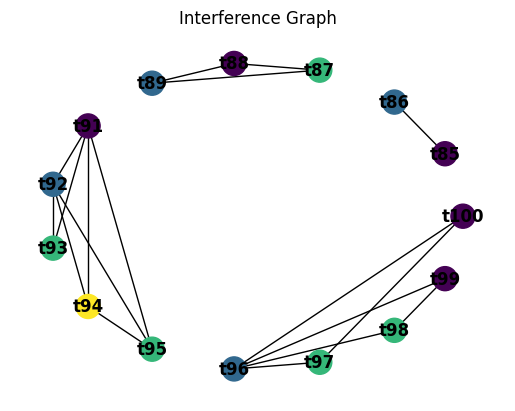

single nodes: {'local_right.6.arg2', 't84', 't90', 'local_left.5.arg1', 'local_arr.4.arg0'}
color needed: 4
depth {'local_arr.4': 8, 'local_left.5': 16, 'local_right.6': 24, 'local_pivotIndex.7': 32}
>   store i64* %local_arr.4.arg0, i64** %local_arr.4, align 8
toR local_arr.4.arg0
toR local_arr.4
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_left.5.arg1, i64* %local_left.5, align 4
toR local_left.5.arg1
toR local_left.5
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_right.6.arg2, i64* %local_right.6, align 4
toR local_right.6.arg2
toR local_right.6
  - ['movq %rdx, -24(%rbp)']
>   %t85 = load i64, i64* %local_left.5, align 4
toR t85
toR local_left.5
  - ['movq -16(%rbp), %r8']
>   %t86 = load i64, i64* %local_right.6, align 4
toR t86
toR local_right.6
  - ['movq -24(%rbp), %r9']
>   %t84 = icmp slt i64 %t85, %t86
toR t85
toR t86
  - ['cmpq %r9, %r8']
>   br i1 %t84, label %if.body5.81, label %if.end5.83
  - ['jge if.end5.83']
>   %t87 = load i64*, i64** %local_arr.4, align 4
toR

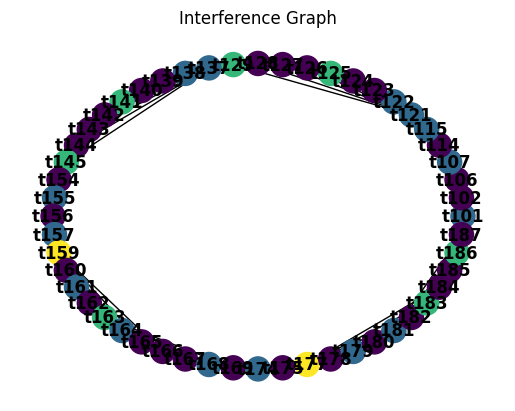

single nodes: {'t153', 't136', 't147', 't172', 't108', 'local_left.9.arg1', 't103', 't176', 't105', 't171', 't120', 't158', 't113', 'local_right.10.arg2', 't188', 't104', 't173', 't146', 't131', 't170', 't130', 'local_arr.8.arg0'}
color needed: 4
depth {'local_arr.8': 8, 'local_left.9': 16, 'local_right.10': 24, 'local_pivot.11': 32, 'local_i.12': 40, 'local_j.13': 48}
>   store i64* %local_arr.8.arg0, i64** %local_arr.8, align 8
toR local_arr.8.arg0
toR local_arr.8
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_left.9.arg1, i64* %local_left.9, align 4
toR local_left.9.arg1
toR local_left.9
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_right.10.arg2, i64* %local_right.10, align 4
toR local_right.10.arg2
toR local_right.10
  - ['movq %rdx, -24(%rbp)']
>   %t101 = load i64, i64* %local_left.9, align 4
toR t101
toR local_left.9
  - ['movq -16(%rbp), %r9']
>   %t102 = load i64*, i64** %local_arr.8, align 4
toR t102
toR local_arr.8
  - ['movq -8(%rbp), %r8']
>   %t103 = getelementptr 

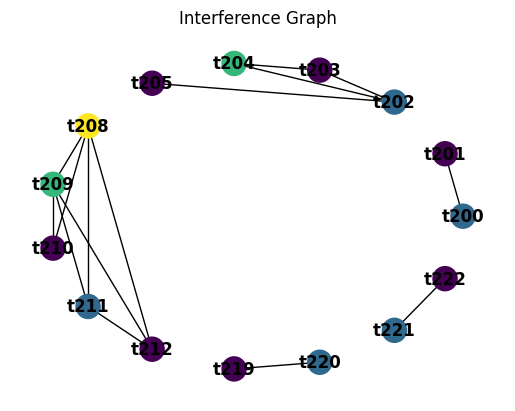

single nodes: {'t228', 't224', 't227', 't207', 't206', 't199', 't226', 't193', 't189', 't190', 't198', 't225', 't223', 't217', 't192', 't218', 't191'}
color needed: 4
depth {'local_arr.14': 8, 'local_n.15': 16, 'local_i.16': 24, 'local_i.17': 32}
>   %t189 = add i64 0, 10005
toR i64 0
toR i64 10005
toR t189
  - ['movq $0, %r8', 'addq $10005, %r8']
>   %t191 = mul i64 %t189, 8
toR t189
toR i64 8
toR t191
  - ['pushq %rax', 'pushq %rdx', 'pushq %rcx', 'movq %r8, %rax', 'movq $8, %rcx', 'imulq %rcx', 'movq %rax, %r8', 'popq %rcx', 'popq %rdx', 'popq %rax']
>   %t192 = call noalias i8* @malloc(i64 %t191)
toR t192
toR t191
  - ['movq %r8, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t190 = bitcast i8* %t192 to i64*
toR t192
toR t190
  - ['movq %r8, %r8']
>   store i64* %t190, i64** %local_arr.14, align 8
toR t190
toR local_arr.14
  - ['movq %r8, -8(%rbp)']
>   store i64 0, i64* %local_n.15, align 4
toR i64 0
toR local_n.15
  - ['movq $0, -16(%rbp)']
>   %t193 = call i64 @main_getInt()
t

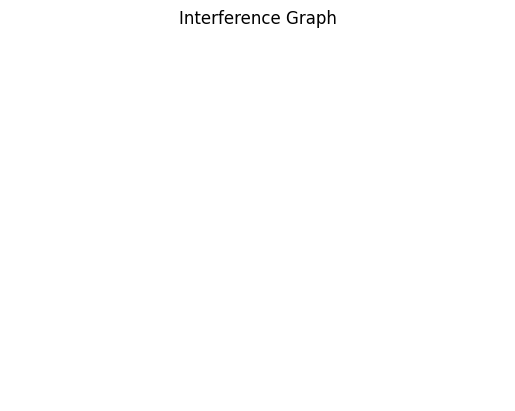

single nodes: set()
color needed: 0
depth {}
>   ret void
  - []
-- ASM: --
	.globl main_init
	main_init:
pushq %rbp
movq %rsp, %rbp
subq $0, %rsp
pushq %r8
pushq %r9
pushq %r10
pushq %r11
pushq %r12
pushq %r13
pushq %r14
pushq %r15
  #  ret void
	main_init_end:
popq %r15
popq %r14
popq %r13
popq %r12
popq %r11
popq %r10
popq %r9
popq %r8
movq %rbp, %rsp
popq %rbp
retq
codeGenForFunc main
{}
0 [[1], set(), set()]
1 [[2], set(), set()]
2 [[], set(), set()]
done
count 1
0 {} {} | {} {}
1 {} {} | {} {}
2 {} {} | {} {}
{}
0
set()
coloring {}


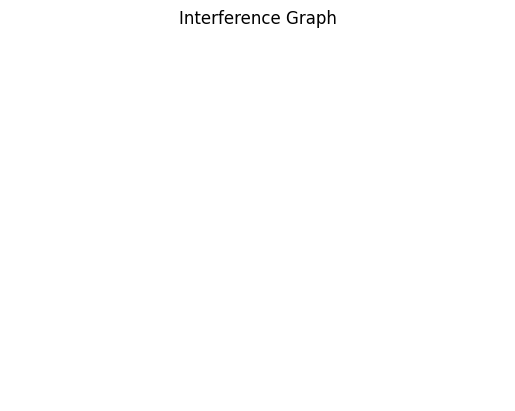

single nodes: set()
color needed: 0
depth {}
>   call void @main_init()
  - ['call main_init@PLT']
>   call void @main_main()
  - ['call main_main@PLT']
>   ret i64 0
toR i64 0
  - ['movq $0, %rax', 'jmp main_end']
-- ASM: --
	.globl main
	main:
pushq %rbp
movq %rsp, %rbp
subq $0, %rsp
pushq %r8
pushq %r9
pushq %r10
pushq %r11
pushq %r12
pushq %r13
pushq %r14
pushq %r15
  #  call void @main_init()
call main_init@PLT
  #  call void @main_main()
call main_main@PLT
  #  ret i64 0
movq $0, %rax
jmp main_end
	main_end:
popq %r15
popq %r14
popq %r13
popq %r12
popq %r11
popq %r10
popq %r9
popq %r8
movq %rbp, %rsp
popq %rbp
retq


In [18]:
ll2asm('../build/sort.ll', 'test.s')